In [ ]:
# Run once, restart kernel and proceed with the next cell
# %pip install --upgrade ipywidgets

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import training
from training import load_config, generate_basic_dataloader, generate_sppf_dataloader, get_model, train_loop, cal_regression_metrics, cal_classification_metrics
from utils.preprocessing import load_image, apply_img_preprocessing

from inference import load_saved_model, pred_degradation_value

# Training

In [3]:
config_path = "./configs/cnn.yaml"
config = load_config(config_path)
pprint(config,)

{'dataset_loc': {'train': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51_degradation_values.csv',
                           'img_dir': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51'},
                 'val': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c_degradation_values.csv',
                         'img_dir': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c'}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 3},
 'results_loc': 'experiment_results/',
 'training': {'batch_size': 1,
              'learning_rate': 0.05,
              'num_epochs': 2,
              'num_workers': 2,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 1}}


In [4]:
# # copy paste config here to edit and experiment
# config = {'dataset_loc': {
#                 'train': {
#                       'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_train.csv',
#                       'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments/train/'},
#                  'val': {
#                      'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_val.csv',
#                      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments/val/'}
#                 },
#          'enable_cuda': True,
#          'model': {'in_channels': 3, 'out_dim': 3},
#          'results_loc': 'experiment_results/',
#          'training': {'batch_size': 1,
#                       'learning_rate': 0.0001,
#                       'num_epochs': 10,
#                       'num_workers': 2,
#                       'resume_checkpoint': None,
#                       'save_checkpoint_freq': 10}
#          }

In [5]:
# copy paste config here to edit and experiment
config = {'dataset_loc': {
                'train': {
                      'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_train_vtest.csv',
                      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments/train/'},
                 'val': {
                     'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_val_vtest.csv',
                     'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments/train/'}
                },
         'enable_cuda': True,
         'model': {'in_channels': 3, 'out_dim': 3},
         'results_loc': 'experiment_results/',
         'training': {'batch_size': 1,
                      'learning_rate': 0.0001,
                      'num_epochs': 80,
                      'num_workers': 2,
                      'resume_checkpoint': None,
                      'save_checkpoint_freq': 10}
         }

In [6]:
# get required config parameters
model_config = config["model"]
train_config = config["training"]
dataset_config = config["dataset_loc"]

In [7]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [8]:
# update preprocessing config if required
# resize_height, resize_width = preprocess_config["resize_height"], preprocess_config["resize_height"]

# # in case one wants to try out different transformations
# img_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((resize_height, resize_width)),   # ensure resize same is used for mask by setting preprocess_config
#     transforms.ToTensor()
# ])

# generate train data loader
train_loader, train_size = generate_sppf_dataloader(image_dir=dataset_config["train"]["img_dir"],
                                               degradation_values_csv=dataset_config["train"]["degradation_values_csv"],
                                               batch_size=train_config["batch_size"],
                                               num_workers=train_config["num_workers"], transform=None   # send new transform here if required
                                        )

# generate validation data loader
val_loader, val_size = generate_sppf_dataloader(image_dir=dataset_config["val"]["img_dir"],
                                                degradation_values_csv=dataset_config["val"]["degradation_values_csv"],
                                                batch_size=train_config["batch_size"],
                                                num_workers=train_config["num_workers"], transform=None 
                                                )

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 950
Validation Dataset loaded. #samples: 100


Image batch shape: torch.Size([1, 3, 239, 513])
Degradation label shape: torch.Size([1, 3])
Degradation target: tensor([1, 0, 0])


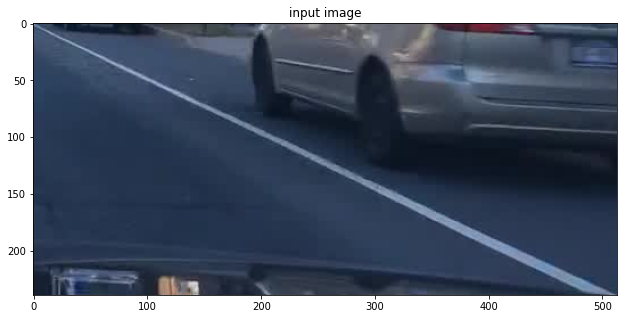

In [9]:
# Ensure that we are getting correct data from data loaders
batch_img, degradation_values = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("Degradation label shape:", degradation_values.shape) 

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

# sample_mask = batch_mask[0].numpy()   # (c, h, w)
# sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(sample_img)
ax.set_title("input image")

print("Degradation target:", degradation_values[0])

In [10]:
# Initializing the model, loss function, and the optimizer
model_name = "cnn_sppf"
model = get_model(model_name, in_channels=model_config['in_channels'], out_dim=model_config['out_dim'])
model = model.to(training.DEVICE)

# criterion = nn.MSELoss() # Loss for regression
class_weights = torch.tensor([2.0, 3.33, 5.0]).to(training.DEVICE)  # Weights for class 0, 1, and 2
criterion = nn.CrossEntropyLoss(weight=class_weights) # Loss for classification multi-class classification
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"], weight_decay=1e-7)

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))

In [11]:
# from torchinfo import summary
# summary(model, input_size=(1, 3, 10, 10))

In [12]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"])

Training Started...


epoch: 0:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 0:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/80], Train Loss: 3.1961, Val Loss: 3.1997, Epoch execution time: 20.63 sec


epoch: 1:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/80], Train Loss: 3.1386, Val Loss: 3.1121, Epoch execution time: 7.96 sec


epoch: 2:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 2:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/80], Train Loss: 3.0402, Val Loss: 3.0584, Epoch execution time: 8.34 sec


epoch: 3:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 3:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/80], Train Loss: 2.9216, Val Loss: 2.8913, Epoch execution time: 8.56 sec


epoch: 4:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 4:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/80], Train Loss: 2.7943, Val Loss: 2.8545, Epoch execution time: 7.75 sec


epoch: 5:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 5:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/80], Train Loss: 2.7244, Val Loss: 2.7152, Epoch execution time: 9.03 sec


epoch: 6:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 6:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/80], Train Loss: 2.6407, Val Loss: 2.6620, Epoch execution time: 6.54 sec


epoch: 7:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 7:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/80], Train Loss: 2.5940, Val Loss: 2.6594, Epoch execution time: 7.57 sec


epoch: 8:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 8:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/80], Train Loss: 2.6006, Val Loss: 2.6080, Epoch execution time: 8.29 sec


epoch: 9:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 9:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/80], Train Loss: 2.5775, Val Loss: 2.5300, Epoch execution time: 7.98 sec


epoch: 10:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 10:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/80], Train Loss: 2.5398, Val Loss: 2.5584, Epoch execution time: 7.59 sec


epoch: 11:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 11:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/80], Train Loss: 2.5520, Val Loss: 2.4669, Epoch execution time: 8.25 sec


epoch: 12:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 12:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/80], Train Loss: 2.5326, Val Loss: 2.4657, Epoch execution time: 7.87 sec


epoch: 13:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 13:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/80], Train Loss: 2.5160, Val Loss: 2.5156, Epoch execution time: 6.99 sec


epoch: 14:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 14:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/80], Train Loss: 2.5211, Val Loss: 2.6055, Epoch execution time: 7.39 sec


epoch: 15:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 15:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16/80], Train Loss: 2.4988, Val Loss: 2.5771, Epoch execution time: 7.7 sec


epoch: 16:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 16:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17/80], Train Loss: 2.4765, Val Loss: 2.4503, Epoch execution time: 8.11 sec


epoch: 17:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 17:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18/80], Train Loss: 2.4580, Val Loss: 2.4851, Epoch execution time: 7.63 sec


epoch: 18:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 18:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19/80], Train Loss: 2.4556, Val Loss: 2.5551, Epoch execution time: 7.59 sec


epoch: 19:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 19:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/80], Train Loss: 2.4553, Val Loss: 2.6727, Epoch execution time: 8.31 sec


epoch: 20:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 20:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21/80], Train Loss: 2.4462, Val Loss: 2.8659, Epoch execution time: 6.95 sec


epoch: 21:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 21:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22/80], Train Loss: 2.4489, Val Loss: 2.6078, Epoch execution time: 7.86 sec


epoch: 22:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 22:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23/80], Train Loss: 2.4365, Val Loss: 2.5576, Epoch execution time: 7.57 sec


epoch: 23:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 23:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24/80], Train Loss: 2.4146, Val Loss: 2.4692, Epoch execution time: 7.83 sec


epoch: 24:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 24:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25/80], Train Loss: 2.4457, Val Loss: 2.4894, Epoch execution time: 7.52 sec


epoch: 25:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 25:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26/80], Train Loss: 2.3884, Val Loss: 2.4399, Epoch execution time: 8.55 sec


epoch: 26:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 26:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27/80], Train Loss: 2.3974, Val Loss: 2.4115, Epoch execution time: 8.53 sec


epoch: 27:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 27:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28/80], Train Loss: 2.4063, Val Loss: 2.5201, Epoch execution time: 6.65 sec


epoch: 28:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 28:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29/80], Train Loss: 2.3630, Val Loss: 2.5461, Epoch execution time: 7.05 sec


epoch: 29:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 29:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30/80], Train Loss: 2.3798, Val Loss: 2.4040, Epoch execution time: 8.92 sec


epoch: 30:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31/80], Train Loss: 2.3580, Val Loss: 2.5480, Epoch execution time: 7.96 sec


epoch: 31:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 31:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32/80], Train Loss: 2.3638, Val Loss: 2.7541, Epoch execution time: 7.3 sec


epoch: 32:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 32:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33/80], Train Loss: 2.3587, Val Loss: 2.6084, Epoch execution time: 7.9 sec


epoch: 33:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 33:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34/80], Train Loss: 2.3452, Val Loss: 2.5390, Epoch execution time: 8.52 sec


epoch: 34:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 34:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35/80], Train Loss: 2.3405, Val Loss: 2.6265, Epoch execution time: 8.04 sec


epoch: 35:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 35:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36/80], Train Loss: 2.3157, Val Loss: 2.4985, Epoch execution time: 8.41 sec


epoch: 36:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 36:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37/80], Train Loss: 2.3111, Val Loss: 2.5083, Epoch execution time: 8.78 sec


epoch: 37:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 37:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38/80], Train Loss: 2.3104, Val Loss: 2.4608, Epoch execution time: 8.19 sec


epoch: 38:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 38:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39/80], Train Loss: 2.3230, Val Loss: 2.5575, Epoch execution time: 8.35 sec


epoch: 39:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 39:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40/80], Train Loss: 2.3323, Val Loss: 2.4356, Epoch execution time: 8.5 sec


epoch: 40:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 40:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41/80], Train Loss: 2.2924, Val Loss: 2.4622, Epoch execution time: 8.39 sec


epoch: 41:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 41:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42/80], Train Loss: 2.2929, Val Loss: 2.3727, Epoch execution time: 7.57 sec


epoch: 42:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 42:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43/80], Train Loss: 2.2788, Val Loss: 2.3953, Epoch execution time: 7.61 sec


epoch: 43:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 43:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44/80], Train Loss: 2.2636, Val Loss: 2.4832, Epoch execution time: 7.96 sec


epoch: 44:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 44:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45/80], Train Loss: 2.2636, Val Loss: 2.4115, Epoch execution time: 8.03 sec


epoch: 45:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 45:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46/80], Train Loss: 2.2612, Val Loss: 2.4527, Epoch execution time: 7.88 sec


epoch: 46:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 46:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47/80], Train Loss: 2.2342, Val Loss: 2.8764, Epoch execution time: 6.96 sec


epoch: 47:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 47:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48/80], Train Loss: 2.2393, Val Loss: 2.3718, Epoch execution time: 7.36 sec


epoch: 48:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 48:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49/80], Train Loss: 2.2218, Val Loss: 2.5049, Epoch execution time: 7.85 sec


epoch: 49:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 49:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50/80], Train Loss: 2.2033, Val Loss: 2.5175, Epoch execution time: 8.34 sec


epoch: 50:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 50:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [51/80], Train Loss: 2.2092, Val Loss: 2.4916, Epoch execution time: 7.34 sec


epoch: 51:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 51:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [52/80], Train Loss: 2.2190, Val Loss: 2.4413, Epoch execution time: 6.69 sec


epoch: 52:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 52:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [53/80], Train Loss: 2.1673, Val Loss: 2.4833, Epoch execution time: 7.33 sec


epoch: 53:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 53:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [54/80], Train Loss: 2.1893, Val Loss: 2.4687, Epoch execution time: 9.19 sec


epoch: 54:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 54:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [55/80], Train Loss: 2.1832, Val Loss: 2.4805, Epoch execution time: 5.95 sec


epoch: 55:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 55:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [56/80], Train Loss: 2.1793, Val Loss: 2.4667, Epoch execution time: 7.2 sec


epoch: 56:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 56:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [57/80], Train Loss: 2.1560, Val Loss: 2.4263, Epoch execution time: 8.06 sec


epoch: 57:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 57:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [58/80], Train Loss: 2.1469, Val Loss: 2.3391, Epoch execution time: 8.27 sec


epoch: 58:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 58:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [59/80], Train Loss: 2.1203, Val Loss: 2.5741, Epoch execution time: 8.58 sec


epoch: 59:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 59:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [60/80], Train Loss: 2.1180, Val Loss: 2.4540, Epoch execution time: 8.92 sec


epoch: 60:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 60:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [61/80], Train Loss: 2.1238, Val Loss: 2.4103, Epoch execution time: 8.32 sec


epoch: 61:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 61:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [62/80], Train Loss: 2.0810, Val Loss: 2.6233, Epoch execution time: 7.4 sec


epoch: 62:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 62:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [63/80], Train Loss: 2.0878, Val Loss: 2.4418, Epoch execution time: 8.68 sec


epoch: 63:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 63:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [64/80], Train Loss: 2.0716, Val Loss: 2.4860, Epoch execution time: 8.75 sec


epoch: 64:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 64:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [65/80], Train Loss: 2.0576, Val Loss: 2.3982, Epoch execution time: 7.75 sec


epoch: 65:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 65:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [66/80], Train Loss: 2.0539, Val Loss: 2.5044, Epoch execution time: 7.56 sec


epoch: 66:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 66:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [67/80], Train Loss: 2.0424, Val Loss: 2.4949, Epoch execution time: 8.54 sec


epoch: 67:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 67:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [68/80], Train Loss: 2.0185, Val Loss: 2.4957, Epoch execution time: 7.87 sec


epoch: 68:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 68:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [69/80], Train Loss: 2.0112, Val Loss: 2.4443, Epoch execution time: 7.71 sec


epoch: 69:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 69:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [70/80], Train Loss: 2.0197, Val Loss: 2.4187, Epoch execution time: 7.23 sec


epoch: 70:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 70:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [71/80], Train Loss: 2.0102, Val Loss: 2.3962, Epoch execution time: 9.24 sec


epoch: 71:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 71:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [72/80], Train Loss: 1.9841, Val Loss: 2.3986, Epoch execution time: 7.07 sec


epoch: 72:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 72:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [73/80], Train Loss: 1.9540, Val Loss: 2.6350, Epoch execution time: 7.32 sec


epoch: 73:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 73:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [74/80], Train Loss: 1.9403, Val Loss: 2.4669, Epoch execution time: 8.25 sec


epoch: 74:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 74:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [75/80], Train Loss: 1.9215, Val Loss: 2.3941, Epoch execution time: 8.89 sec


epoch: 75:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 75:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [76/80], Train Loss: 1.9143, Val Loss: 2.3991, Epoch execution time: 7.69 sec


epoch: 76:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 76:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [77/80], Train Loss: 1.9172, Val Loss: 2.5837, Epoch execution time: 7.59 sec


epoch: 77:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 77:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [78/80], Train Loss: 1.9352, Val Loss: 2.4977, Epoch execution time: 6.31 sec


epoch: 78:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 78:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [79/80], Train Loss: 1.8788, Val Loss: 2.4593, Epoch execution time: 7.11 sec


epoch: 79:   0%|          | 0/950 [00:00<?, ?it/s]

epoch: 79:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [80/80], Train Loss: 1.8737, Val Loss: 2.5046, Epoch execution time: 8.09 sec
   Learning curve saved to experiment_results/train_log/learning_curve_2025-04-07_03-14-38.png
   Learning history saved to experiment_results/train_log/learning_history_2025-04-07_03-14-38.json
Model saved at: experiment_results/checkpoints/cnn_sppf_final_2025-04-07_03-14-38.pth
Training Completed! Total time: 10.7067 min


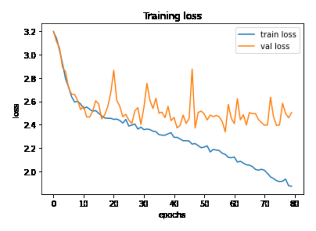

In [16]:
# open saved learning curve
# plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_02-16-57.png"
plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_03-14-38.png"
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [17]:
# Evaluate model performance at end of training using different losses
train_metrics, train_cm = cal_classification_metrics(model, train_loader, num_classes=3)
val_metrics, val_cm = cal_classification_metrics(model, val_loader, num_classes=3)

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,train,val
accuracy,0.7316,0.68
precision,0.7555,0.68
recall,0.7316,0.68
f1,0.7387,0.68


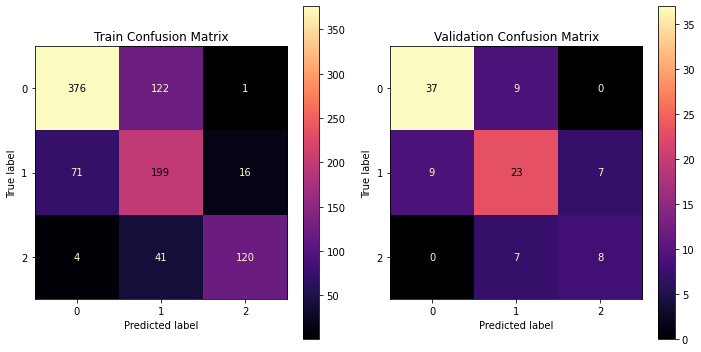

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

stats = pd.DataFrame([train_metrics, val_metrics], index=["train", "val"]).T
display(stats)

# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plot the train confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp_train.plot(ax=ax[0], cmap='magma')
ax[0].set_title("Train Confusion Matrix")

# Plot the validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp_val.plot(ax=ax[1], cmap='magma')  # Plot on the second subplot
ax[1].set_title("Validation Confusion Matrix")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Inference

In [ ]:
saved_weight_path = "experiment_results/checkpoints/cnn_sppf_final_2025-03-13_18-02-43.pth"

model_name = "cnn_sppf"
model_config = {'in_channels': 3, 'out_dim': 1}

In [ ]:
# update preprocessing according to training
resize_height, resize_width = 720, 1280

# Define the image transformations
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resize_height, resize_width)),   # ensure resize is same as used during training for loaded model 
    transforms.ToTensor()
])

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

In [ ]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

In [ ]:
test_img_path = "../damage_ratio_calc_data/segmented_objects/191_jpg.rf.e27c030e763e58ce48964e670158b6e7/191_jpg.rf.e27c030e763e58ce48964e670158b6e7_object_4.png"
test_img = load_image(test_img_path)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [ ]:
pred_val = pred_degradation_value(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
print("Predicticted degradation value:", pred_val)